# Thermodynamics

Thermodynamics can make or break the feasibility of a separation process. When designing a separation process, it is crucial to understand the applicability of common equations of state and activity models. In this tutorial, we will see how the validity of different thermodynamic models is affected by temperature, pressure, and mixture compositions to help reinforce key heuristics for property package selection.

## Mixture properties

In BioSTEAM, mixture properties are estimated as a molar-weighted average of pure-component properties at a reference pressure (1 atm) plus the contribution of non-ideal interactions (i.e., excess properties) estimated by equations of state. For example, the heat capacity of a mixture is computed as:

$$ C_p^\mathrm{mixture}(z, T, P) = \sum_i z_i \cdot C_{p, i}^\mathrm{pure\ ideal}(T, P_\mathrm{ref}) + C_p^\mathrm{mixture\ excess}(z, T, P)$$
$$ C_p^\mathrm{mixture}(z, T, P) = \sum_i z_i \cdot \bigg (C_{p, i}^\mathrm{pure}(T, P_\mathrm{ref})  - C_{p, i}^\mathrm{pure\ excess}(T, P_{ref}) \bigg ) + C_p^\mathrm{mixture\ excess}(z, T, P)$$

- $C_p$ - Heat capacity [J/K/mol].
- $z$ - Molar fraction [-].
- $T$ - Temperature [K].
- $P$ - Pressure [Pa].
- $P_{\mathrm{ref}}$ - Reference pressure [Pa].
- $i$ - Arbitrary chemical.

BioSTEAM uses the most rigorous correlations available within the database to estimate pure component properties. While thermodynamically inconsistent, it provides more accurate estimates than using equations of state to estimate pure component properties. For thermodynamic consistency, pure component properties need to be selected to be based on ideal gas. The equation above only applies to mixture properties on a molar basis (e.g., enthalpy, heat capacity). Some mixture properties cannot be calculated through equations of state (e.g., conductivity) and are estimated by mixing rules such as a simple molar-weighted average:

$$ \kappa_{\mathrm{mixture}}(z, T, P) = \sum_i z_i \cdot \kappa_i(T, P) $$

- $\kappa$ - Conductivity [W/m/K] .

## Phase Equilibrium

Phase equilibrium is attained when the sum of the Gibb's free energy across all phases is minimized. For this to happen, the fugacity (i.e., the tendency of a chemical to leave a phase) must be the same across all phases: 

$$ f^\alpha_i = f^\beta_i $$

- $f^\alpha$ - Fugacity in phase $\alpha$ [Pa].
- $f^\beta$ - Fugacity in phase $\beta$  [Pa].

For vapor-liquid equilibrium, this is equivalent to the following equation:

$$ \Phi_i y_i P = \gamma_i x_i P_{\mathrm{sat},i} F_i $$

- $P$ - Pressure [Pa].
- $P_\mathrm{sat}$ - Saturation vapor pressure [Pa].
- $\Phi$ - Fugacity coefficient [-].
- $F$ - Poynting correction factor [-].
- $y$ - Vapor molar fraction [-].
- $x$ - Liquid molar fraction [-].
- $\gamma$ - Activity coefficient [-].

In BioSTEAM, you can select the specific models used for fugacity coefficients, activity coefficients, and the Poynting correction factor (in addition to the pure component vapor pressure).

## Equations of state

The most simple equation of state is ideal gas, which assumes no interaction between molecules and the volume of each molecule is infinitesimally small. These assumptions makes the model agnostic to the chemical components and their properties. Ideal gas can be a sensible assumption at low pressures (<5 atm) and high temperatures (>298.15 K), particularly for hydrocarbon mixtures. 

$$ P =\frac{RT}{V} $$

At high pressures and/or low temperatures, molecular interactions become significant and may impact mass and energy balances within a process. In such cases, the Peng Robinson model is commonly used to model hydrocarbon mixtures:

$$ P = \frac{RT}{V-b}-\frac{a\alpha(T)}{V(V+b)+b(V-b)} $$

- $\alpha$, $a$, $b$ - functions of chemical properties including the critical temperature, critical pressure, and the accentric factor.

For highly polar mixtures with multiple functional groups, an equation of state may not be enough to model chemical interactions within the liquid. In such cases, an activity model like the UNIFAC group contribution method may improve phase equilibrium calculations, particularly for liquid-liquid equilibrium.   

$$ \gamma = \mathrm{UNIFAC}(x, T, P)$$

## Ideal gas vs. Peng Robinson

Let's compare the ideal gas and Peng Robinson equations of state for a simple hydrocarbon mixture to understand its impact on energy balances and phase equilibrium. We start by creating our property packages:

In [1]:
import biosteam as bst
import numpy as np
hydrocarbon_chemicals = ['Methane', 'Ethane', 'Propane', 'n-Butane']
IG_thermo = bst.Thermo(hydrocarbon_chemicals, pkg='ideal gas')
IG_thermo.chemicals.set_alias('n-Butane', 'Butane')
IG_thermo

Thermo(
    chemicals=CompiledChemicals([Methane, Ethane, Propane, n-Butane]),
    mixture=IdealMixture(...
        include_excess_energies=False
    ),
    Gamma=IdealActivityCoefficients,
    Phi=IdealFugacityCoefficients,
    PCF=MockPoyintingCorrectionFactors
)


In [2]:
PR_thermo = bst.Thermo(
    hydrocarbon_chemicals, 
    pkg='Peng Robinson',
    # By default, activity coefficients are ignored, but can be added with the following:
    # Gamma=bst.PR78ActivityCoefficients
)
PR_thermo.chemicals.set_alias('n-Butane', 'Butane')
PR_thermo

Thermo(
    chemicals=CompiledChemicals([Methane, Ethane, Propane, n-Butane]),
    mixture=PR78Mixture(...),
    Gamma=IdealActivityCoefficients,
    Phi=PR78FugacityCoefficients,
    PCF=MockPoyintingCorrectionFactors
)


Let's have a look at the impact of temperature and pressure on the heat capacity:

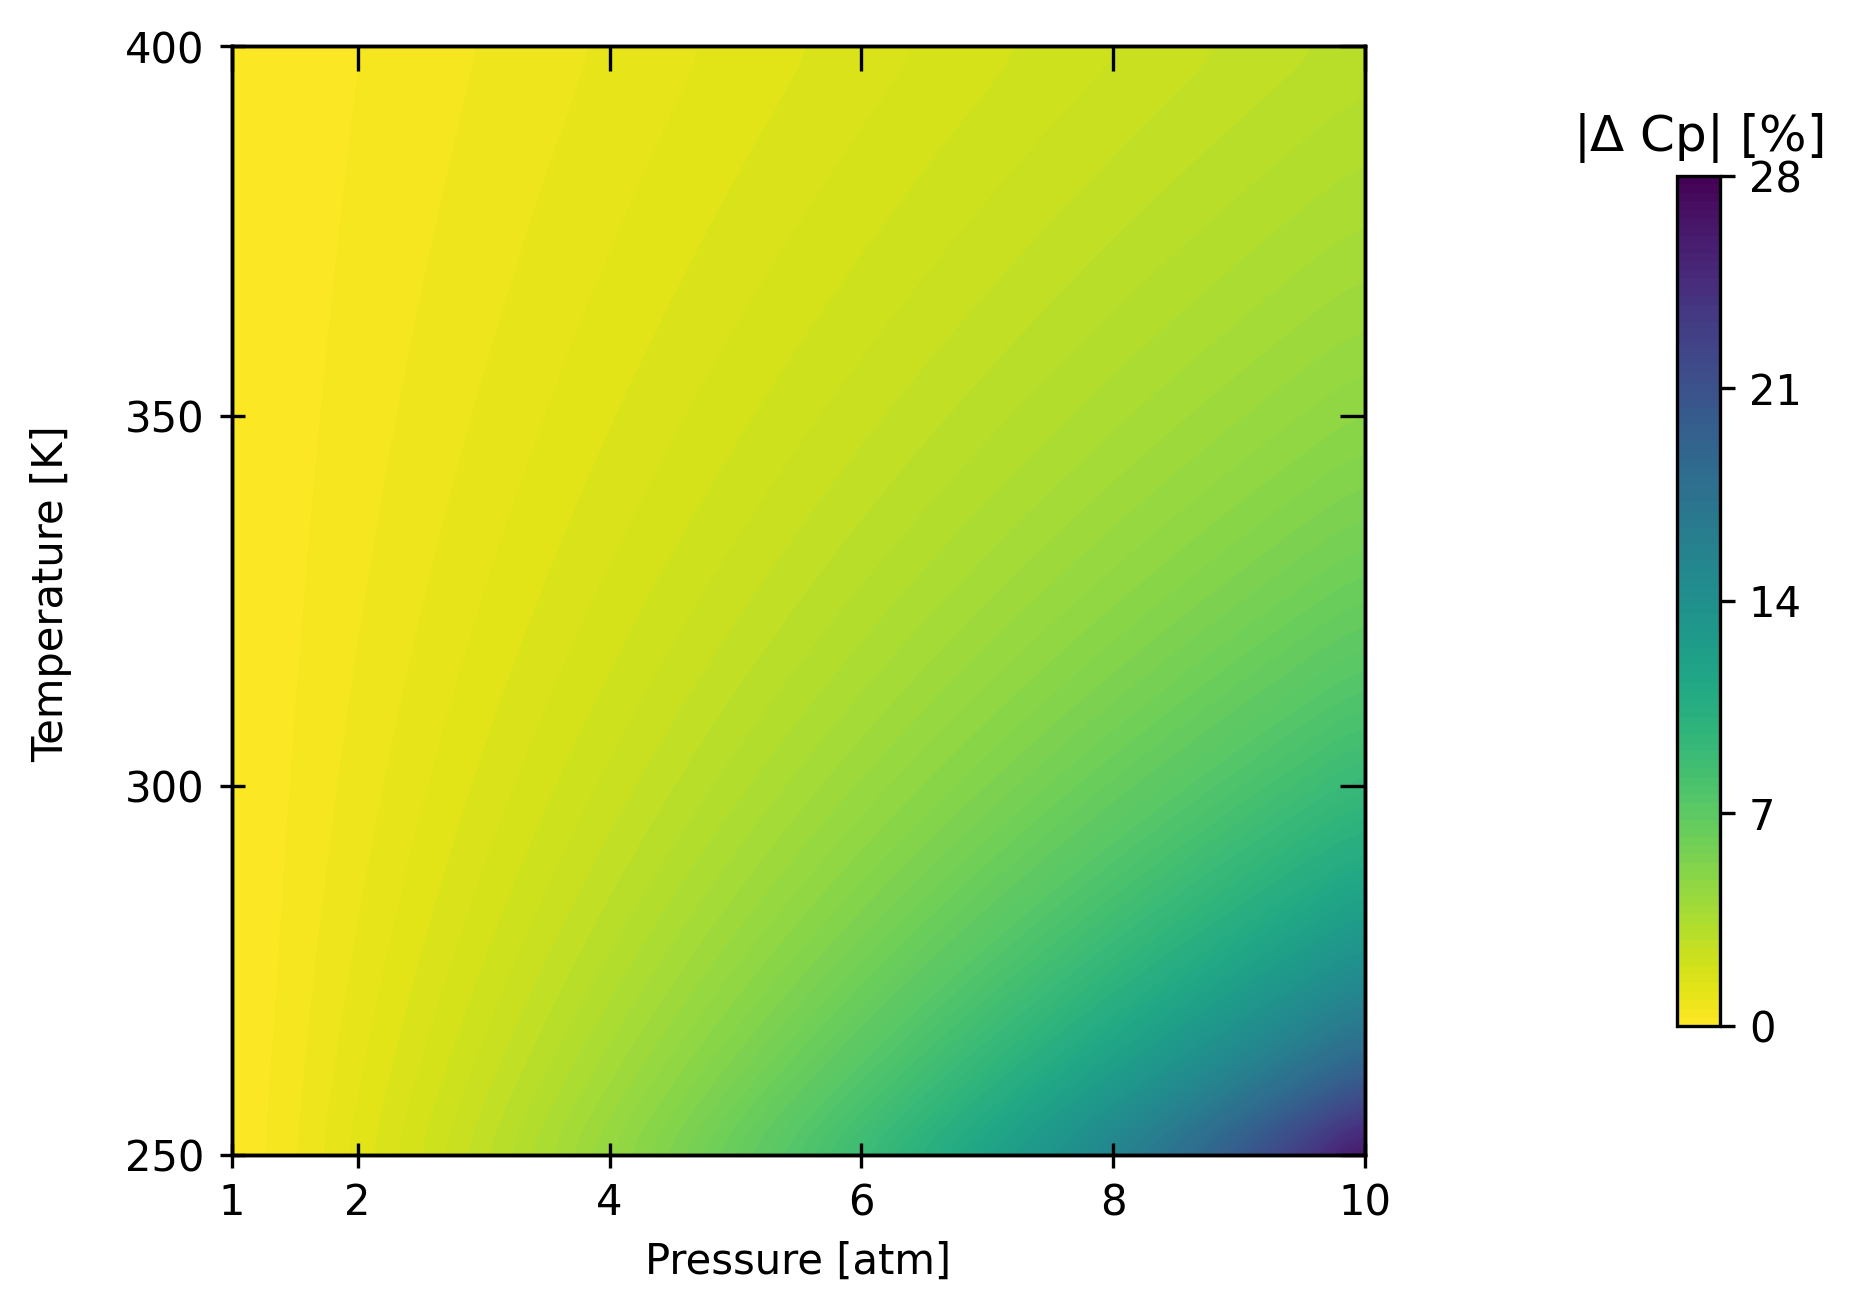

In [3]:
flow_rates = dict(
    Methane=0.05,
    Ethane=0.2, 
    Propane=0.2, 
    Butane=0.2,
    units='kmol/hr',
)
hydrocarbons_IG = bst.Stream(
    None,
    **flow_rates,
    thermo=IG_thermo,
)
hydrocarbons_PR = bst.Stream(
    None,
    **flow_rates,
    thermo=PR_thermo,
)
streams = (hydrocarbons_IG, hydrocarbons_PR)

def delta_Cp(P, T):
    Cp = np.zeros(2)
    for i, s in enumerate(streams): 
        s.phase = 'g'
        s.T = T
        s.P = 101325 * P
        Cp[i] = s.Cp
    return 100 * np.abs((Cp[0] - Cp[1]) / Cp[1])

X, Y, Z = bst.plots.generate_contour_data(
    delta_Cp,
    xlim=[1, 10],
    ylim=[250, 400], 
    n=50,
)

# Plot contours
fig, axes, CSs, CB, other_axes = bst.plots.plot_contour(
    X, Y, Z, 
    xlabel='Pressure [atm]',
    ylabel='Temperature [K]',
    xticks=[1, 2, 4, 6, 8, 10],
    yticks=[250, 300, 350, 400],
    metric_bars=[
        bst.plots.MetricBar(r'|$\Delta$ Cp| [%]', ticks=[0, 7, 14, 21, 28], N_levels=100, cmap='viridis_r'),
    ],
    label=False,
)

The heat capacity at high temperatures and low pressures can be off significantly! It is important to account for chemical interactions in such conditions for a process model to make sense. Now let's have a look at the impact on vapor-liquid equilibrium.

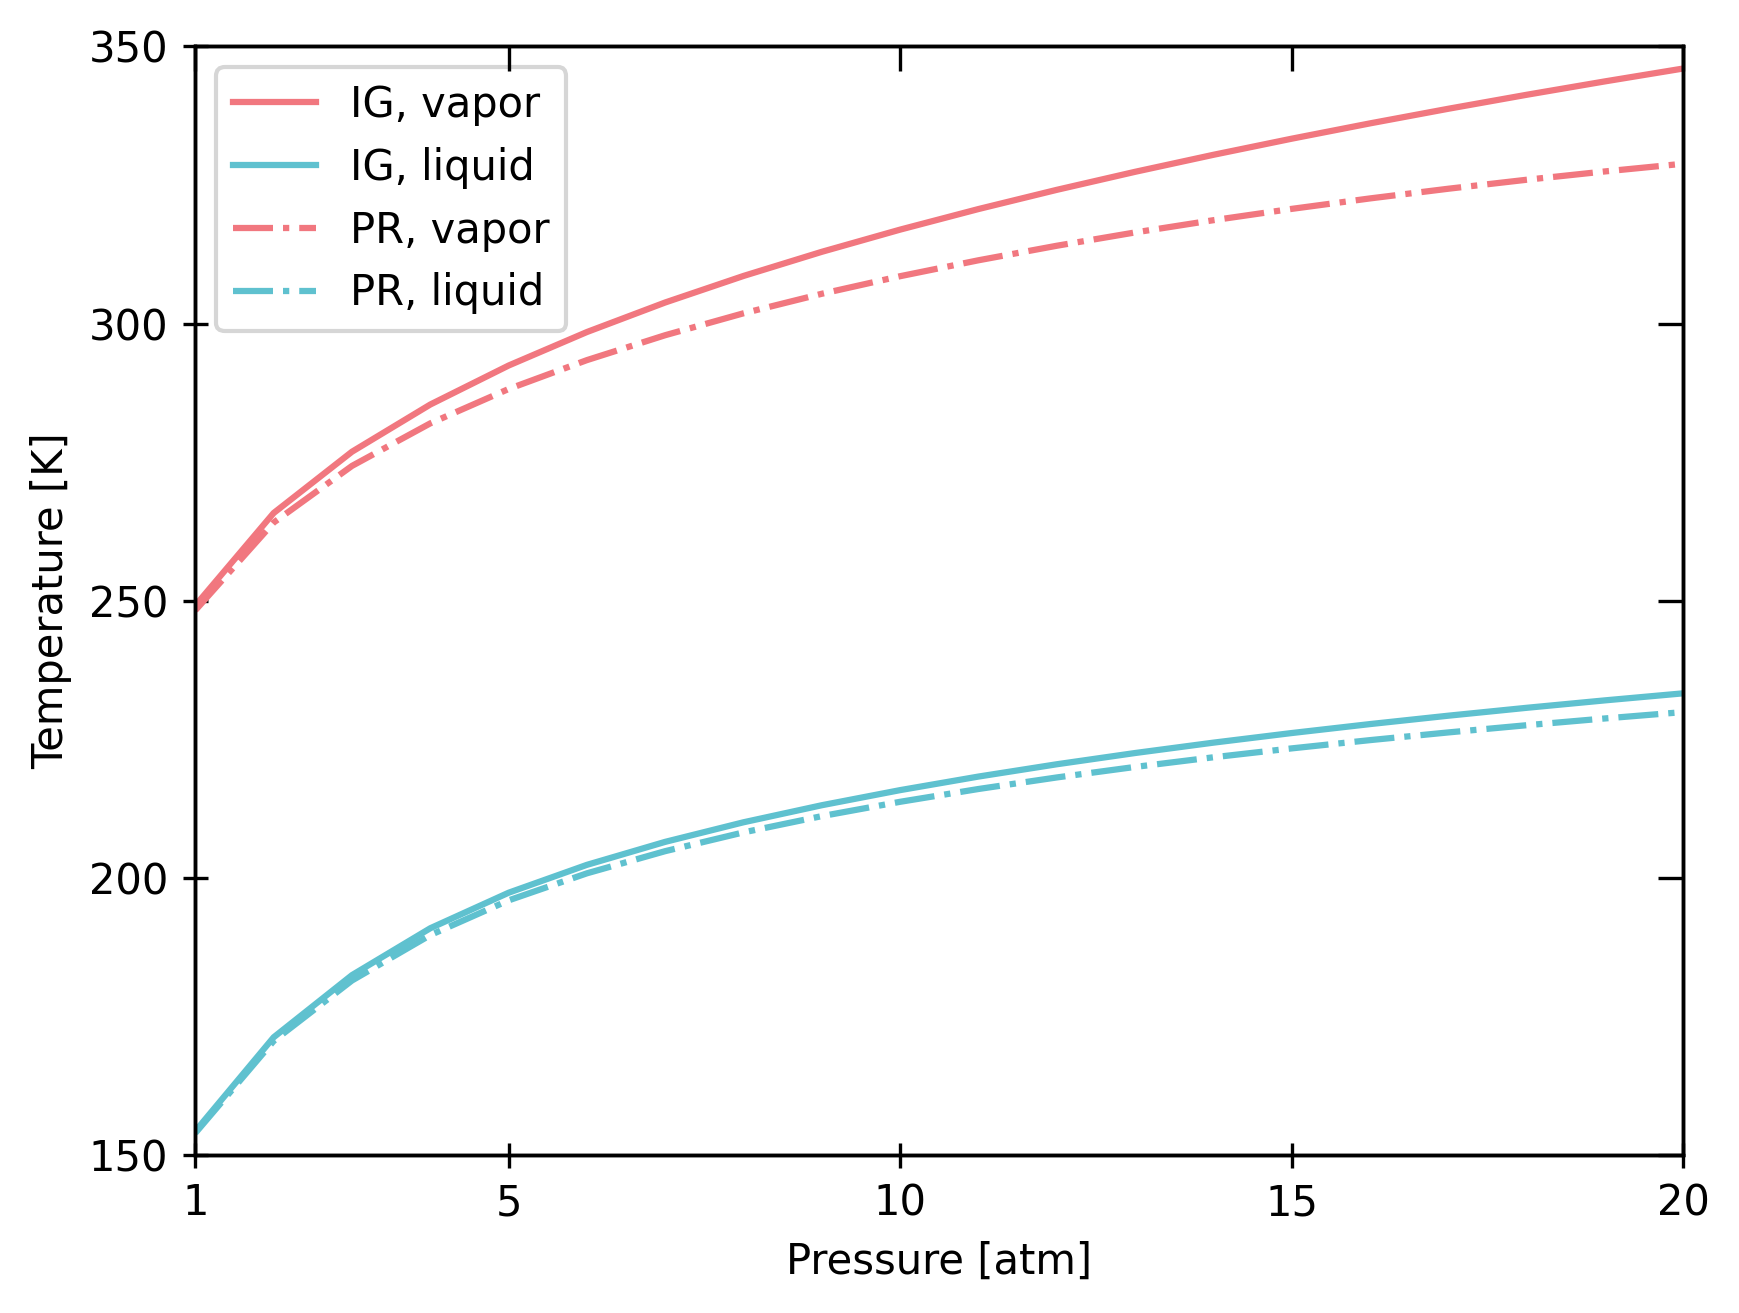

In [4]:
bst.plot_vle_phase_envelope(
    IDs=hydrocarbon_chemicals,
    zs=hydrocarbons_PR.z_mol,
    P_range=[1, 20],
    xticks=[1, 5, 10, 15, 20],
    yticks=[150, 200, 250, 300, 350],
    thermo=[IG_thermo, PR_thermo],
    labels=['IG', 'PR'],
)

Chemical interactions can significantly impact phase equilibrium at high pressures. The property package assumptions are important in assessing a production process.

## Ideal gas vs. UNIFAC activity model

Let's compare the ideal gas and UNIFAC activity model property packages for a highly polar mixture to understand its impact on the phase equilibrium. We start by creating our property packages:

In [5]:
polar_chemicals = ['H2O', 'Ethanol', 'Isobutanol', 'AceticAcid']
IG_thermo = bst.Thermo(polar_chemicals, pkg='ideal gas')
IG_thermo

Thermo(
    chemicals=CompiledChemicals([H2O, Ethanol, Isobutanol, AceticAcid]),
    mixture=IdealMixture(...
        include_excess_energies=False
    ),
    Gamma=IdealActivityCoefficients,
    Phi=IdealFugacityCoefficients,
    PCF=MockPoyintingCorrectionFactors
)


In [6]:
UNIFAC_thermo = bst.Thermo(polar_chemicals, pkg='Dortmund-UNIFAC')
UNIFAC_thermo

Thermo(
    chemicals=CompiledChemicals([H2O, Ethanol, Isobutanol, AceticAcid]),
    mixture=IdealMixture(...
        include_excess_energies=False
    ),
    Gamma=DortmundActivityCoefficients,
    Phi=IdealFugacityCoefficients,
    PCF=MockPoyintingCorrectionFactors
)


Let's have a look at the impact on the phase equilibrium:

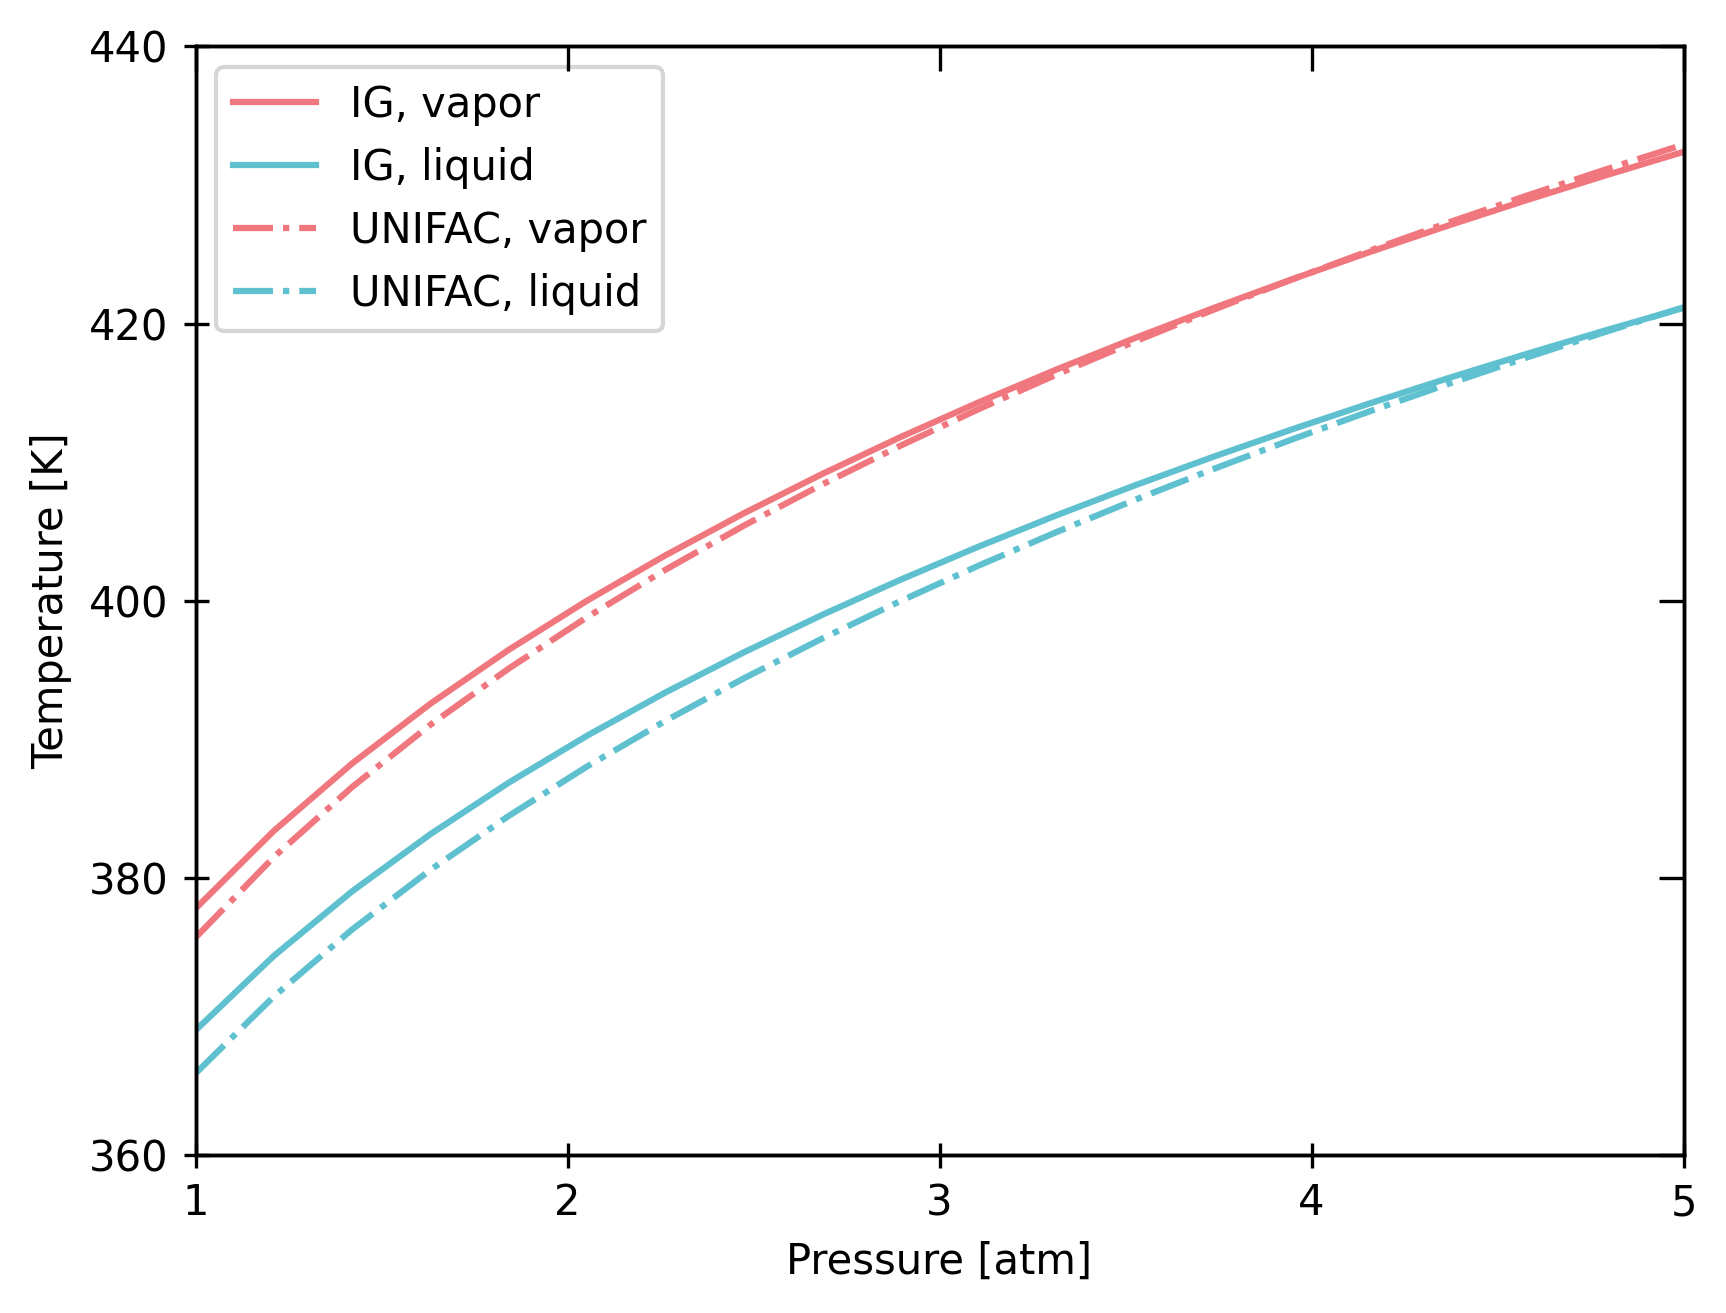

In [7]:
flow_rates = dict(
    H2O=0.05,
    Ethanol=0.2, 
    Isobutanol=0.2, 
    AceticAcid=0.2,
    units='kmol/hr',
)
stream = bst.Stream(
    None,
    **flow_rates,
    thermo=IG_thermo,
)
bst.plot_vle_phase_envelope(
    IDs=polar_chemicals,
    zs=stream.z_mol,
    P_range=[1, 5],
    xticks=[1, 2, 3, 4, 5],
    yticks=[360, 380, 400, 420, 440],
    thermo=[IG_thermo, UNIFAC_thermo],
    labels=['IG', 'UNIFAC'],
)

Chemical interactions can significantly impact phase equilibrium, particularly at low temperatures.

## UNIFAC activity model with ideal gas vs. with Peng Robinson

Let's compare the UNIFAC activity model with ideal gas against with Peng Robinson. 

In [8]:
PR_UNIFAC_thermo = bst.Thermo(polar_chemicals, pkg='Peng Robinson | Dortmund-UNIFAC')
PR_UNIFAC_thermo

Thermo(
    chemicals=CompiledChemicals([H2O, Ethanol, Isobutanol, AceticAcid]),
    mixture=PR78Mixture(...),
    Gamma=DortmundActivityCoefficients,
    Phi=PR78FugacityCoefficients,
    PCF=MockPoyintingCorrectionFactors
)


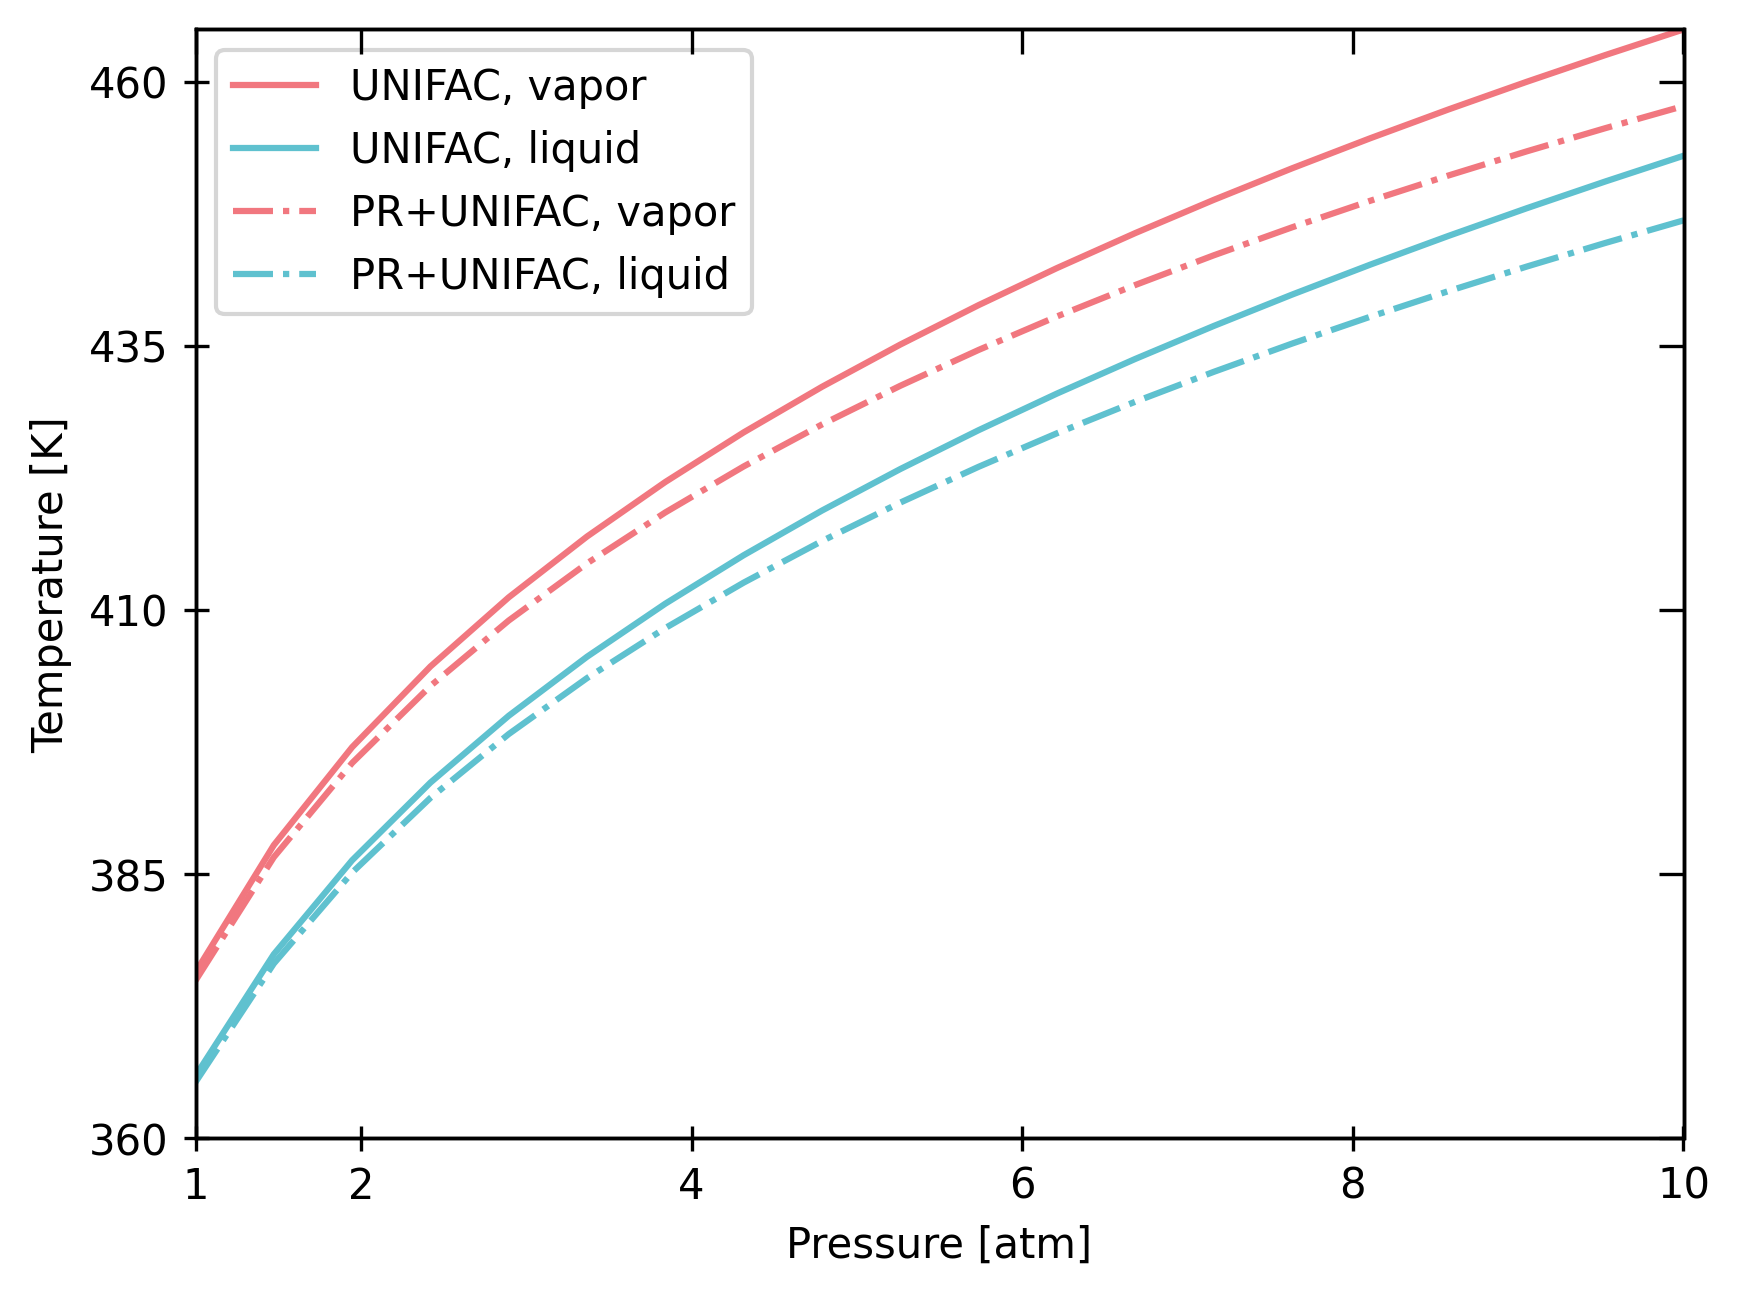

In [9]:
flow_rates = dict(
    H2O=0.05,
    Ethanol=0.2, 
    Isobutanol=0.2, 
    AceticAcid=0.2,
    units='kmol/hr',
)
stream = bst.Stream(
    None,
    **flow_rates,
    thermo=UNIFAC_thermo,
)
bst.plot_vle_phase_envelope(
    IDs=polar_chemicals,
    zs=stream.z_mol,
    P_range=[1, 10],
    xticks=[1, 2, 4, 6, 8, 10],
    yticks=[360, 385, 410, 435, 460],
    thermo=[UNIFAC_thermo, PR_UNIFAC_thermo],
    labels=['UNIFAC', 'PR+UNIFAC'],
)

In conclusion, property package assumptions are important in assessing a production process!